In [1]:
import numpy as np
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading in stock data 
data = yfinance.download('IDT')
print(data.shape)
data['Date'] = data.index
data.head()

[*********************100%***********************]  1 of 1 completed
(4780, 6)


,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2001-05-16,33.601013,33.601013,33.601013,33.601013,12.179194,0,2001-05-16
2001-05-17,33.601013,33.601013,33.601013,33.601013,12.179194,0,2001-05-17
2001-05-18,33.601013,33.601013,33.601013,33.601013,12.179194,0,2001-05-18
2001-05-21,33.601013,33.601013,33.601013,33.601013,12.179194,0,2001-05-21
2001-05-22,33.601013,33.601013,33.601013,33.601013,12.179194,0,2001-05-22


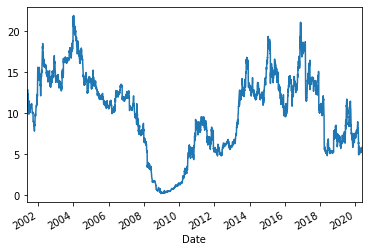

In [3]:
# Adjusted closing price
data['Adj Close'].plot()

In [43]:
#Necessary libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [46]:
# Creating data set for model
new_data = data[['Date','Close']]
new_data.dropna(axis=1,inplace=True)
new_data.reset_index(drop=True,inplace=True)
print(new_data.shape)
new_data.head()

(4780, 2)


/Users/HarrisonHoffman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Close
0,2001-05-16,33.601013
1,2001-05-17,33.601013
2,2001-05-18,33.601013
3,2001-05-21,33.601013
4,2001-05-22,33.601013


In [47]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:4200,:]
valid = dataset[4200:,:]

In [48]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Number of days to look back
look_back = 60

# Number of days to predict
pred_days = 1


X_train, y_train = [], []

for i in range(60,len(train)):
    X_train.append(scaled_data[i-look_back:i,0])
    y_train.append(scaled_data[i:i+pred_days,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [49]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(pred_days))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=15, batch_size=100, verbose=2)

Epoch 1/15
 - 3s - loss: 0.0168
Epoch 2/15
 - 2s - loss: 6.3438e-04
Epoch 3/15
 - 2s - loss: 5.2778e-04
Epoch 4/15
 - 2s - loss: 5.1410e-04
Epoch 5/15
 - 2s - loss: 5.1948e-04
Epoch 6/15
 - 2s - loss: 4.9097e-04
Epoch 7/15
 - 3s - loss: 4.8234e-04
Epoch 8/15
 - 2s - loss: 4.6885e-04
Epoch 9/15
 - 2s - loss: 4.5542e-04
Epoch 10/15
 - 2s - loss: 4.3810e-04
Epoch 11/15
 - 2s - loss: 4.3059e-04
Epoch 12/15
 - 2s - loss: 4.0710e-04
Epoch 13/15
 - 2s - loss: 3.9343e-04
Epoch 14/15
 - 2s - loss: 3.7503e-04
Epoch 15/15
 - 2s - loss: 3.5886e-04


In [51]:
#predicting 246 days, using past 60 days at each time step
inputs = new_data[len(new_data) - len(valid) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [58]:
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)

In [54]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [55]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.808830053088032

/Users/HarrisonHoffman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


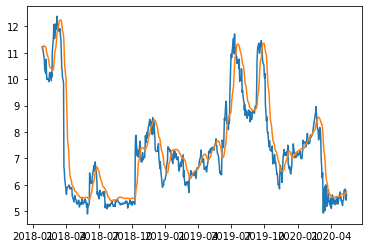

In [57]:
#for plotting
train = new_data[:4200]
valid = new_data[4200:]
valid['Predictions'] = closing_price
#plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])